In [2]:
import torch
import torch.nn as nn
from torch.utils.checkpoint import checkpoint
import torch.nn.utils.prune as prune
from torchvision import transforms, datasets, models
import tqdm
import matplotlib.pyplot as plt

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

# Directories for the split datasets
train_dir = 'train'
test_dir = 'test'
validation_dir = 'valid'

CUDA is available. Using GPU.


Hyperparameters

In [3]:
batch_size = 32
learning_rate = 0.001
weight_decay = 0.01
epochs = 10

In [4]:
# Correctly ordered transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness and contrast changes
    transforms.RandomRotation(degrees=20),  # Random rotation up to 20 degrees
    transforms.RandomPerspective(distortion_scale=0.5),  # Random perspective transform
    transforms.GaussianBlur(kernel_size=3),  # Random Gaussian blur
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1)], p=0.5),  # Random brightness change
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(train_loader)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of batches in train_loader: {len(train_loader)}")

Number of training samples: 6009
Number of batches in train_loader: 188


In [5]:
class CustomClassificationHead(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CustomClassificationHead, self).__init__()
        # No changes here as this part is not as memory intensive
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.batch_norm = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, 512)  # Consider reducing size if necessary
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(512, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the features
        x = self.batch_norm(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.log_softmax(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        densenet = models.densenet201(pretrained=True)
        mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Remove classification layers
        densenet.classifier = nn.Identity()
        mobilenet.classifier = nn.Sequential(*list(mobilenet.classifier.children())[:-1], nn.Identity())
        
        self.densenet = densenet
        self.mobilenet = mobilenet
        
        # Feature reduction layer
        self.feature_reduction = nn.Linear(1920 + 1280, 1024)  # Example: Reducing to 1024 features
        
        # Adjusted classification head for reduced feature size
        self.classification_head = CustomClassificationHead(num_features=1024, num_classes=2)

    def forward(self, x):
        # Using checkpointing for memory efficiency
        features_densenet = checkpoint(self.densenet, x)
        features_mobilenet = checkpoint(self.mobilenet, x)
        
        # Concatenate features along the feature dimension
        features_combined = torch.cat((features_densenet, features_mobilenet), dim=1)
        
        # Reduce feature size
        reduced_features = self.feature_reduction(features_combined)
        
        # Forward pass through the classification head
        x = self.classification_head(reduced_features)
        return x

# Initialize the combined model
combined_model = CombinedModel()

# Assuming 'device' is defined (e.g., cuda or cpu)
combined_model=combined_model.to(device)


# Example: Pruning 20% of connections in the dense1 layer of the classification head by weight magnitude
prune.l1_unstructured(combined_model.classification_head.dense1, name='weight', amount=0.2)

c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to p

Linear(in_features=1024, out_features=512, bias=True)

In [6]:
torch.cuda.empty_cache()  # Clear unused memory

inputs, labels = next(iter(train_loader))
inputs, labels = inputs.to(device), labels.to(device)

optimizer = torch.optim.AdamW(combined_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.NLLLoss()

Epoch 1/10 - Training:   0%|          | 0/188 [00:00<?, ?it/s]c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Validating: 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]


Epoch 1: Train Loss: 0.3050, Train Acc: 88.13%, Valid Loss: 0.2764, Valid Acc: 89.07%


Validating: 100%|██████████| 63/63 [00:40<00:00,  1.57it/s]


Epoch 2: Train Loss: 0.2634, Train Acc: 89.30%, Valid Loss: 0.2698, Valid Acc: 89.92%


Validating: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


Epoch 3: Train Loss: 0.2524, Train Acc: 89.83%, Valid Loss: 0.2607, Valid Acc: 89.87%


Validating: 100%|██████████| 63/63 [00:40<00:00,  1.57it/s]


Epoch 4: Train Loss: 0.2458, Train Acc: 90.01%, Valid Loss: 0.2676, Valid Acc: 88.27%


Validating: 100%|██████████| 63/63 [00:39<00:00,  1.59it/s]


Epoch 5: Train Loss: 0.2434, Train Acc: 89.73%, Valid Loss: 0.2548, Valid Acc: 90.16%


Validating: 100%|██████████| 63/63 [00:39<00:00,  1.59it/s]


Epoch 6: Train Loss: 0.2343, Train Acc: 90.61%, Valid Loss: 0.2556, Valid Acc: 90.31%


Validating: 100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


Epoch 7: Train Loss: 0.2390, Train Acc: 90.46%, Valid Loss: 0.2486, Valid Acc: 89.87%


Validating: 100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


Epoch 8: Train Loss: 0.2316, Train Acc: 90.76%, Valid Loss: 0.2610, Valid Acc: 89.87%


Validating: 100%|██████████| 63/63 [00:39<00:00,  1.59it/s]


Epoch 9: Train Loss: 0.2331, Train Acc: 90.88%, Valid Loss: 0.2437, Valid Acc: 90.41%


Validating: 100%|██████████| 63/63 [00:39<00:00,  1.59it/s]


Epoch 10: Train Loss: 0.2295, Train Acc: 90.38%, Valid Loss: 0.2488, Valid Acc: 89.82%


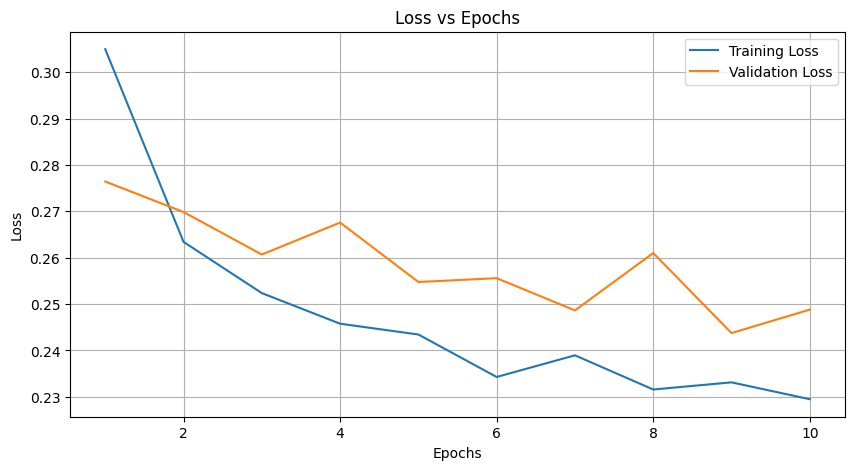

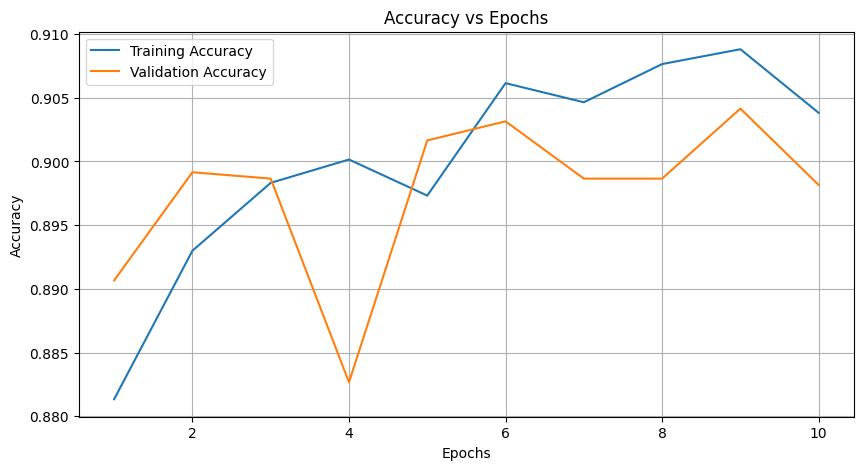

In [7]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(epochs):
    combined_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = combined_model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    combined_model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(valid_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = combined_model(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    valid_accuracy = correct / total

    valid_losses.append(valid_loss / len(valid_loader))
    valid_accuracies.append(valid_accuracy)
    
    print(f"Epoch {epoch+1}: Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Acc: {train_accuracy * 100:.2f}%, "
          f"Valid Loss: {valid_loss / len(valid_loader):.4f}, "
          f"Valid Acc: {valid_accuracy * 100:.2f}%")

# Plot loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Directory for the test dataset
test_dir = 'test'

# Create test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loader for test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Set the model to evaluation mode
combined_model.eval()

# Iterate over test data
for inputs, labels in tqdm.tqdm(test_loader, desc="Testing"):
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Forward pass
    outputs = combined_model(inputs)
    
    # Get predictions
    _, predicted = torch.max(outputs, 1)
    
    # Append predictions and labels to lists
    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)

# Calculate precision
test_precision = precision_score(all_labels, all_predictions)

# Calculate recall
test_recall = recall_score(all_labels, all_predictions)

# Calculate F1 score
test_f1_score = f1_score(all_labels, all_predictions)

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

Testing:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Testing: 100%|██████████| 63/63 [00:49<00:00,  1.28it/s]

Confusion Matrix:
[[  54  172]
 [  25 1752]]
Test Accuracy: 0.9016
Test Precision: 0.9106
Test Recall: 0.9859
Test F1 Score: 0.9468
